## 1. <font color='red'> Install and Import Required Libraries </font>





In [32]:
# Install the wikipediaapi library

!pip install wikipedia-api

In [33]:
# Import required libraries

import numpy as np
import pandas as pd
import wikipediaapi

## 2. <font color = 'red'> Document Chunking </font>

We will generate embeddings for texts related to various Wikipedia articles. But since you are using large blocks of text, before generating the embeddings, you need to generate the chunks. Let's start with a basic chunking technique, and chunk the text by paragraph.

In [34]:
# Call the Wikipedia function through a user_agent and specify the language

string = "SemSearchDemo/1.0 (Akshay G;)"
wiki_wiki = wikipediaapi.Wikipedia(user_agent= string, language= 'en')

In [35]:
# Extract the wikipedia page for the page - " The Shawshank Redemption"

page = wiki_wiki.page("The Shawshank Redemption")

In [36]:
# Check the entire page's text

page.text

'The Shawshank Redemption is a 1994 American prison drama film written and directed by Frank Darabont, based on the 1982 Stephen King novella Rita Hayworth and Shawshank Redemption. The film tells the story of banker Andy Dufresne (Tim Robbins), who is sentenced to life in Shawshank State Penitentiary for the murders of his wife and her lover, despite his claims of innocence. Over the following two decades, he befriends a fellow prisoner, contraband smuggler Ellis "Red" Redding (Morgan Freeman), and becomes instrumental in a money laundering operation led by the prison warden Samuel Norton (Bob Gunton). William Sadler, Clancy Brown, Gil Bellows, and James Whitmore appear in supporting roles.\nDarabont purchased the film rights to King\'s story in 1987, but development did not begin until five years later, when he wrote the script over eight weeks. Two weeks after submitting his script to Castle Rock Entertainment, Darabont secured a $25 million budget to produce The Shawshank Redemptio

In [37]:
page.sections

[Section: Plot (1):
 In 1947, Portland, Maine banker Andy Dufresne arrives at Shawshank State Prison to serve two consecutive life sentences for murdering his wife and her lover. He is befriended by Ellis "Red" Redding, a contraband smuggler serving a life sentence, who procures a rock hammer and a large poster of Rita Hayworth for Andy. Assigned to work in the prison laundry, Andy is frequently raped by "the Sisters" prison gang and their leader, Bogs Diamond.
 In 1949, Andy overhears the captain of the guards, Byron Hadley, complaining about being taxed on an inheritance and offers to help him shelter the money legally. After the Sisters beat Andy to near-death, Hadley beats and cripples Bogs, who is subsequently transferred to a minimum security hospital; Andy is not attacked again. Warden Samuel Norton meets Andy and reassigns him to the decrepit prison library to assist elderly inmate Brooks Hatlen, a front to use Andy's financial expertise to manage financial matters for other pr

### 2.1 <font color = 'red'> Fixed-Size Chunking </font>

In fixed-size chunking, the document is split into fixed-size windows with each window representing a separate document chunk.

In [38]:
# Function to split text into fixed-size chunks

def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

In [39]:
# Function to extract and store Wikipedia page information

def process_page(page_title):

    page = wiki_wiki.page(page_title)

    if page.exists():
        page_text = page.text
        chunk_size = 1000  # Set your desired chunk size (in characters)

        text_chunks = split_text_into_chunks(page_text, chunk_size)

        # Create a DataFrame to store the chunks and page title
        data = {'Title': [], 'Chunk Text': []}

        for idx, chunk in enumerate(text_chunks):
            data['Title'].append(page_title)
            data['Chunk Text'].append(chunk)

        return pd.DataFrame(data)

    else:
        print(f"The page '{page_title}' does not exist on Wikipedia.")
        return None

#### Chunking for multiple documents

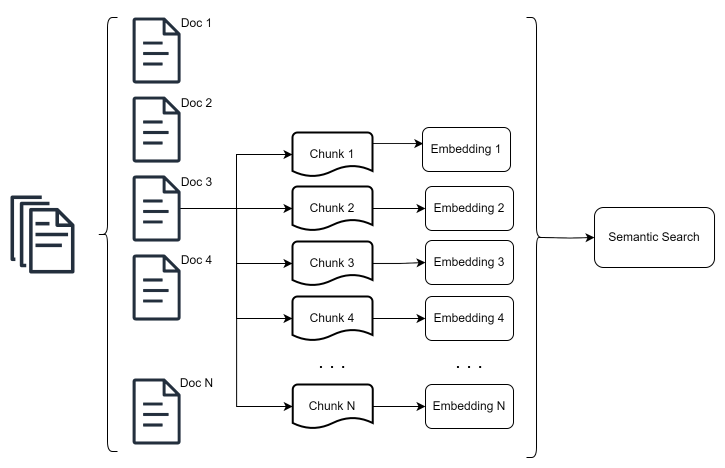

In [40]:
# Iterating over all page titles to create the final df with individual chunks

page_titles = ["The Shawshank Redemption", "The Dark Knight", "Pulp Fiction", "The Godfather", "Goodfellas"]

all_dfs = []

for title in page_titles:
    df = process_page(title)
    if df is not None:
        all_dfs.append(df)


fixed_chunk_df = pd.concat(all_dfs, ignore_index=True)
fixed_chunk_df

,Title,Chunk Text
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,which started pre-production in January 1993. ...
2,The Shawshank Redemption,"receive multiple award nominations, including ..."
3,The Shawshank Redemption,"Registry, finding it ""culturally, historically..."
4,The Shawshank Redemption,Andy's financial expertise to manage financial...
...,...,...
278,Goodfellas,a very important movie to me and Goodfellas re...
279,Goodfellas,announced that the AMC Network had put a telev...
280,Goodfellas,includes language and/or cultural stereotypes ...
281,Goodfellas,in Queens.. The movie had its behind-the-scene...


### <font color = 'red'>  2.2 Chunking by Paragraph </font>

Here, we will try to chunk and extract individual paragraphs using the newline character.

In [41]:
# Defining some redundant sections

redundant_sections = [
    "See also",
    "References",
    "External links",
    "Further reading",
    "Footnotes",
    "Bibliography",
    "Sources",
    "Citations",
    "Literature",
    "Footnotes",
    "Notes and references",
    "Photo gallery",
    "Works cited",
    "Photos",
    "Gallery",
    "Notes",
    "References and sources",
    "References and notes",
]

In [42]:
# Function to extract and store Wikipedia page information

def extract_wikipedia_page(page_title):
    page = wiki_wiki.page(page_title)
    if page.exists():
        title = page.title
        paragraphs = []

        # Extract introduction if available
        if page.summary:
            paragraphs.extend(page.summary.split('\n'))

        # Extract paragraphs from sections
        for section in page.sections:
          if section.title not in redundant_sections:
            extract_paragraphs(section, paragraphs)

        return title, paragraphs

    else:
        return None, None

In [43]:
# Function to extract paragraphs from sections
def extract_paragraphs(section, accumulated_text):
    accumulated_text.extend(section.text.split('\n'))
    for sub_section in section.sections:
        extract_paragraphs(sub_section, accumulated_text)

In [44]:
# List of Wikipedia page titles
page_titles = ["The Shawshank Redemption", "The Dark Knight", "Pulp Fiction", "The Godfather", "Goodfellas"]

# Initialize lists to store data
titles = []
paragraphs = []

# Extract data and store in lists
for title in page_titles:
    extracted_title, extracted_paragraphs = extract_wikipedia_page(title)
    if extracted_title and extracted_paragraphs:
        titles.extend([extracted_title] * len(extracted_paragraphs))
        paragraphs.extend(extracted_paragraphs)

# Create a DataFrame
data = {'Title': titles, 'Chunk Text': paragraphs}
para_chunk_df = pd.DataFrame(data)

# Display the DataFrame
para_chunk_df = para_chunk_df[para_chunk_df['Chunk Text'] != '']  # Remove empty paragraphs
para_chunk_df = para_chunk_df.reset_index(drop=True)   # Reset index
para_chunk_df

,Title,Chunk Text
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,Darabont purchased the film rights to King's s...
2,The Shawshank Redemption,While The Shawshank Redemption received critic...
3,The Shawshank Redemption,"Over 320,000 VHS rental copies were shipped th..."
4,The Shawshank Redemption,"In 1947, Portland, Maine banker Andy Dufresne ..."
...,...,...
436,Goodfellas,AFI's 100 Years... 100 Movies - #94
437,Goodfellas,AFI's 100 Years... 100 Movies (10th Anniversar...
438,Goodfellas,AFI's 10 Top 10 - #2 Gangster film
439,Goodfellas,AFI's 100 Years... 100 Heroes and Villains - T...


### <font color = 'red'>  2.3 Chunking by Sections </font>

Wikipedia already has the page divided into neat sections and subsections. Let's leverage that for chunking.

In [45]:
# Function to extract and store Wikipedia page sections
def extract_wikipedia_sections(page_title):
    page = wiki_wiki.page(page_title)
    if page.exists():
        title = page.title
        sections = []

        # Extract introduction if available
        introduction = page.summary
        if introduction:
            sections.append(("Introduction", introduction))

        # Extract all sections and subsections recursively
        def recursive_extraction(section):
            section_text = section.text
            if section_text:
                sections.append((section.title, section_text))
            for sub_section in section.sections:
                recursive_extraction(sub_section)

        for section in page.sections:
            if section.title not in redundant_sections:
                recursive_extraction(section)

        return title, sections

    else:
        return None, None

In [46]:
# List of Wikipedia page titles
page_titles = ["The Shawshank Redemption", "The Dark Knight", "Pulp Fiction", "The Godfather", "Goodfellas"]

# Initialize lists to store data
titles = []
section_titles = []
section_texts = []

# Extract data and store in lists
for title in page_titles:
    extracted_title, extracted_sections = extract_wikipedia_sections(title)
    if extracted_title and extracted_sections:
        for section_title, section_text in extracted_sections:
            titles.append(extracted_title)
            section_titles.append(section_title)
            section_texts.append(section_text)

# Create a DataFrame
data = {'Title': titles, 'Section Title': section_titles, 'Chunk Text': section_texts}
section_chunk_df = pd.DataFrame(data)

# Display the DataFrame
section_chunk_df = section_chunk_df[section_chunk_df['Chunk Text'] != '']  # Remove empty sections
section_chunk_df = section_chunk_df.reset_index(drop=True)  # Reset index
section_chunk_df

,Title,Section Title,Chunk Text
0,The Shawshank Redemption,Introduction,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,Plot,"In 1947, Portland, Maine banker Andy Dufresne ..."
2,The Shawshank Redemption,Cast,Tim Robbins as Andy Dufresne: A banker sentenc...
3,The Shawshank Redemption,Analysis,The film has been interpreted as being grounde...
4,The Shawshank Redemption,Development,Frank Darabont first collaborated with author ...
...,...,...,...
94,Goodfellas,Box office,"Goodfellas grossed $6.3 million from 1,070 the..."
95,Goodfellas,Critical response,According to review aggregator Rotten Tomatoes...
96,Goodfellas,Lists,The film was ranked the best of 1990 by Roger ...
97,Goodfellas,Accolades,Goodfellas is 1 of 8 films to have won Best Pi...


In [47]:
fixed_chunk_df

,Title,Chunk Text
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,which started pre-production in January 1993. ...
2,The Shawshank Redemption,"receive multiple award nominations, including ..."
3,The Shawshank Redemption,"Registry, finding it ""culturally, historically..."
4,The Shawshank Redemption,Andy's financial expertise to manage financial...
...,...,...
278,Goodfellas,a very important movie to me and Goodfellas re...
279,Goodfellas,announced that the AMC Network had put a telev...
280,Goodfellas,includes language and/or cultural stereotypes ...
281,Goodfellas,in Queens.. The movie had its behind-the-scene...


In [48]:
para_chunk_df

,Title,Chunk Text
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,Darabont purchased the film rights to King's s...
2,The Shawshank Redemption,While The Shawshank Redemption received critic...
3,The Shawshank Redemption,"Over 320,000 VHS rental copies were shipped th..."
4,The Shawshank Redemption,"In 1947, Portland, Maine banker Andy Dufresne ..."
...,...,...
436,Goodfellas,AFI's 100 Years... 100 Movies - #94
437,Goodfellas,AFI's 100 Years... 100 Movies (10th Anniversar...
438,Goodfellas,AFI's 10 Top 10 - #2 Gangster film
439,Goodfellas,AFI's 100 Years... 100 Heroes and Villains - T...


In [49]:
section_chunk_df

,Title,Section Title,Chunk Text
0,The Shawshank Redemption,Introduction,The Shawshank Redemption is a 1994 American pr...
1,The Shawshank Redemption,Plot,"In 1947, Portland, Maine banker Andy Dufresne ..."
2,The Shawshank Redemption,Cast,Tim Robbins as Andy Dufresne: A banker sentenc...
3,The Shawshank Redemption,Analysis,The film has been interpreted as being grounde...
4,The Shawshank Redemption,Development,Frank Darabont first collaborated with author ...
...,...,...,...
94,Goodfellas,Box office,"Goodfellas grossed $6.3 million from 1,070 the..."
95,Goodfellas,Critical response,According to review aggregator Rotten Tomatoes...
96,Goodfellas,Lists,The film was ranked the best of 1990 by Roger ...
97,Goodfellas,Accolades,Goodfellas is 1 of 8 films to have won Best Pi...


## 3. <font color = 'red'> Generating Embeddings </font>

#### Encoding Pipeline

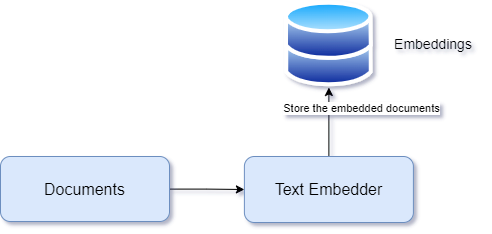

In [50]:
# Install the sentence transformers library

!pip install sentence-transformers

In [51]:
from sentence_transformers import SentenceTransformer, util

In [52]:
# Load pre-trained Sentence Transformer model

model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

In [53]:
# Function to generate embeddings for text
def generate_embeddings(texts):
    embeddings = embedder.encode(texts, convert_to_tensor=True)
    return embeddings

In [54]:
def generate_embeddings_on_df(df):
  df['Embeddings'] = df['Chunk Text'].apply(lambda x: generate_embeddings([x])[0])

In [55]:
# Create embeddings for 'Chunk Text' column on all three dataframes

generate_embeddings_on_df(fixed_chunk_df)

In [56]:
generate_embeddings_on_df(para_chunk_df)

In [57]:
generate_embeddings_on_df(section_chunk_df)

In [58]:
fixed_chunk_df

,Title,Chunk Text,Embeddings
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...,"[tensor(-0.0450), tensor(-0.0140), tensor(-0.0..."
1,The Shawshank Redemption,which started pre-production in January 1993. ...,"[tensor(-0.0272), tensor(-0.0255), tensor(-0.0..."
2,The Shawshank Redemption,"receive multiple award nominations, including ...","[tensor(0.0251), tensor(-0.0277), tensor(-0.01..."
3,The Shawshank Redemption,"Registry, finding it ""culturally, historically...","[tensor(-0.0181), tensor(-0.0055), tensor(-0.0..."
4,The Shawshank Redemption,Andy's financial expertise to manage financial...,"[tensor(-0.0282), tensor(0.0028), tensor(-0.04..."
...,...,...,...
278,Goodfellas,a very important movie to me and Goodfellas re...,"[tensor(-0.0505), tensor(-0.0296), tensor(-0.0..."
279,Goodfellas,announced that the AMC Network had put a telev...,"[tensor(-0.0838), tensor(0.0130), tensor(-0.10..."
280,Goodfellas,includes language and/or cultural stereotypes ...,"[tensor(-0.0847), tensor(0.0096), tensor(-0.07..."
281,Goodfellas,in Queens.. The movie had its behind-the-scene...,"[tensor(-0.0865), tensor(-0.0841), tensor(-0.0..."


In [59]:
para_chunk_df

,Title,Chunk Text,Embeddings
0,The Shawshank Redemption,The Shawshank Redemption is a 1994 American pr...,"[tensor(-0.0596), tensor(-0.0301), tensor(-0.0..."
1,The Shawshank Redemption,Darabont purchased the film rights to King's s...,"[tensor(-0.0351), tensor(-0.0152), tensor(-0.0..."
2,The Shawshank Redemption,While The Shawshank Redemption received critic...,"[tensor(-0.0156), tensor(-0.0270), tensor(-0.0..."
3,The Shawshank Redemption,"Over 320,000 VHS rental copies were shipped th...","[tensor(0.0224), tensor(-0.0345), tensor(-0.02..."
4,The Shawshank Redemption,"In 1947, Portland, Maine banker Andy Dufresne ...","[tensor(-0.0163), tensor(0.0039), tensor(-0.05..."
...,...,...,...
436,Goodfellas,AFI's 100 Years... 100 Movies - #94,"[tensor(-0.0367), tensor(-0.0243), tensor(-0.0..."
437,Goodfellas,AFI's 100 Years... 100 Movies (10th Anniversar...,"[tensor(-0.0572), tensor(-0.0156), tensor(0.00..."
438,Goodfellas,AFI's 10 Top 10 - #2 Gangster film,"[tensor(-0.0587), tensor(-0.0536), tensor(-0.0..."
439,Goodfellas,AFI's 100 Years... 100 Heroes and Villains - T...,"[tensor(-0.0658), tensor(0.0377), tensor(-0.08..."


In [60]:
section_chunk_df

,Title,Section Title,Chunk Text,Embeddings
0,The Shawshank Redemption,Introduction,The Shawshank Redemption is a 1994 American pr...,"[tensor(-0.0461), tensor(-0.0266), tensor(-0.0..."
1,The Shawshank Redemption,Plot,"In 1947, Portland, Maine banker Andy Dufresne ...","[tensor(0.0092), tensor(0.0098), tensor(-0.049..."
2,The Shawshank Redemption,Cast,Tim Robbins as Andy Dufresne: A banker sentenc...,"[tensor(-0.0502), tensor(-0.0536), tensor(-0.1..."
3,The Shawshank Redemption,Analysis,The film has been interpreted as being grounde...,"[tensor(-0.0556), tensor(0.0511), tensor(-0.08..."
4,The Shawshank Redemption,Development,Frank Darabont first collaborated with author ...,"[tensor(-0.0313), tensor(-0.0320), tensor(-0.0..."
...,...,...,...,...
94,Goodfellas,Box office,"Goodfellas grossed $6.3 million from 1,070 the...","[tensor(0.0283), tensor(-0.0623), tensor(-0.01..."
95,Goodfellas,Critical response,According to review aggregator Rotten Tomatoes...,"[tensor(-0.0106), tensor(-0.0307), tensor(-0.1..."
96,Goodfellas,Lists,The film was ranked the best of 1990 by Roger ...,"[tensor(-0.0058), tensor(-0.1028), tensor(-0.0..."
97,Goodfellas,Accolades,Goodfellas is 1 of 8 films to have won Best Pi...,"[tensor(0.0252), tensor(-0.0542), tensor(-0.02..."


In [61]:
fixed_chunk_df['Embeddings'][0]

tensor([-4.5033e-02, -1.3977e-02, -9.2651e-02,  1.9057e-02, -5.0282e-02,
         5.1733e-02,  7.6636e-02,  6.2789e-03,  1.3326e-01, -2.8877e-02,
        -7.8991e-02,  3.4776e-02,  6.7544e-02,  2.7707e-02, -3.2757e-02,
         7.0297e-03, -6.2187e-03,  3.7992e-02,  4.2887e-03, -1.2072e-02,
         4.4106e-02, -3.9875e-03,  3.0265e-02, -2.5034e-02, -5.4251e-02,
        -4.7046e-02,  2.2602e-02, -7.2564e-02, -9.4632e-02,  5.5642e-02,
        -1.2507e-02, -6.7893e-02, -2.8608e-03, -2.0439e-02,  2.9972e-04,
         9.3546e-02,  3.9044e-02, -6.1843e-03, -1.3579e-03, -7.1189e-03,
        -3.8805e-03,  2.7993e-02,  4.0154e-02,  4.7883e-02,  7.8012e-02,
        -6.4884e-02, -1.4063e-02, -7.8476e-02,  7.3105e-03, -9.6542e-02,
        -2.5342e-02,  1.1205e-01,  4.0520e-04,  1.4688e-02,  1.6884e-03,
        -5.7545e-02, -4.6751e-03, -1.0145e-03,  1.2586e-02, -7.7156e-02,
        -3.4486e-02,  6.0280e-03,  2.0064e-02, -1.4259e-02,  7.7491e-02,
         1.0733e-02,  1.7110e-02, -8.4493e-03,  2.0

In [62]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
# Save the embeddings in a CSV

output_path = '/content/drive/MyDrive/Applications of LLMs to create Embeddings for Large Documents/'


# Save the dataframe with embeddings
fixed_chunk_df.to_csv(output_path+"fixed_chunk_embeddings.csv", index=False)
para_chunk_df.to_csv(output_path+"para_chunk_embeddings.csv", index=False)
section_chunk_df.to_csv(output_path+"section_chunk_embeddings.csv", index=False)

# 4. <font color = 'red'> Building the Semantic Search </font>

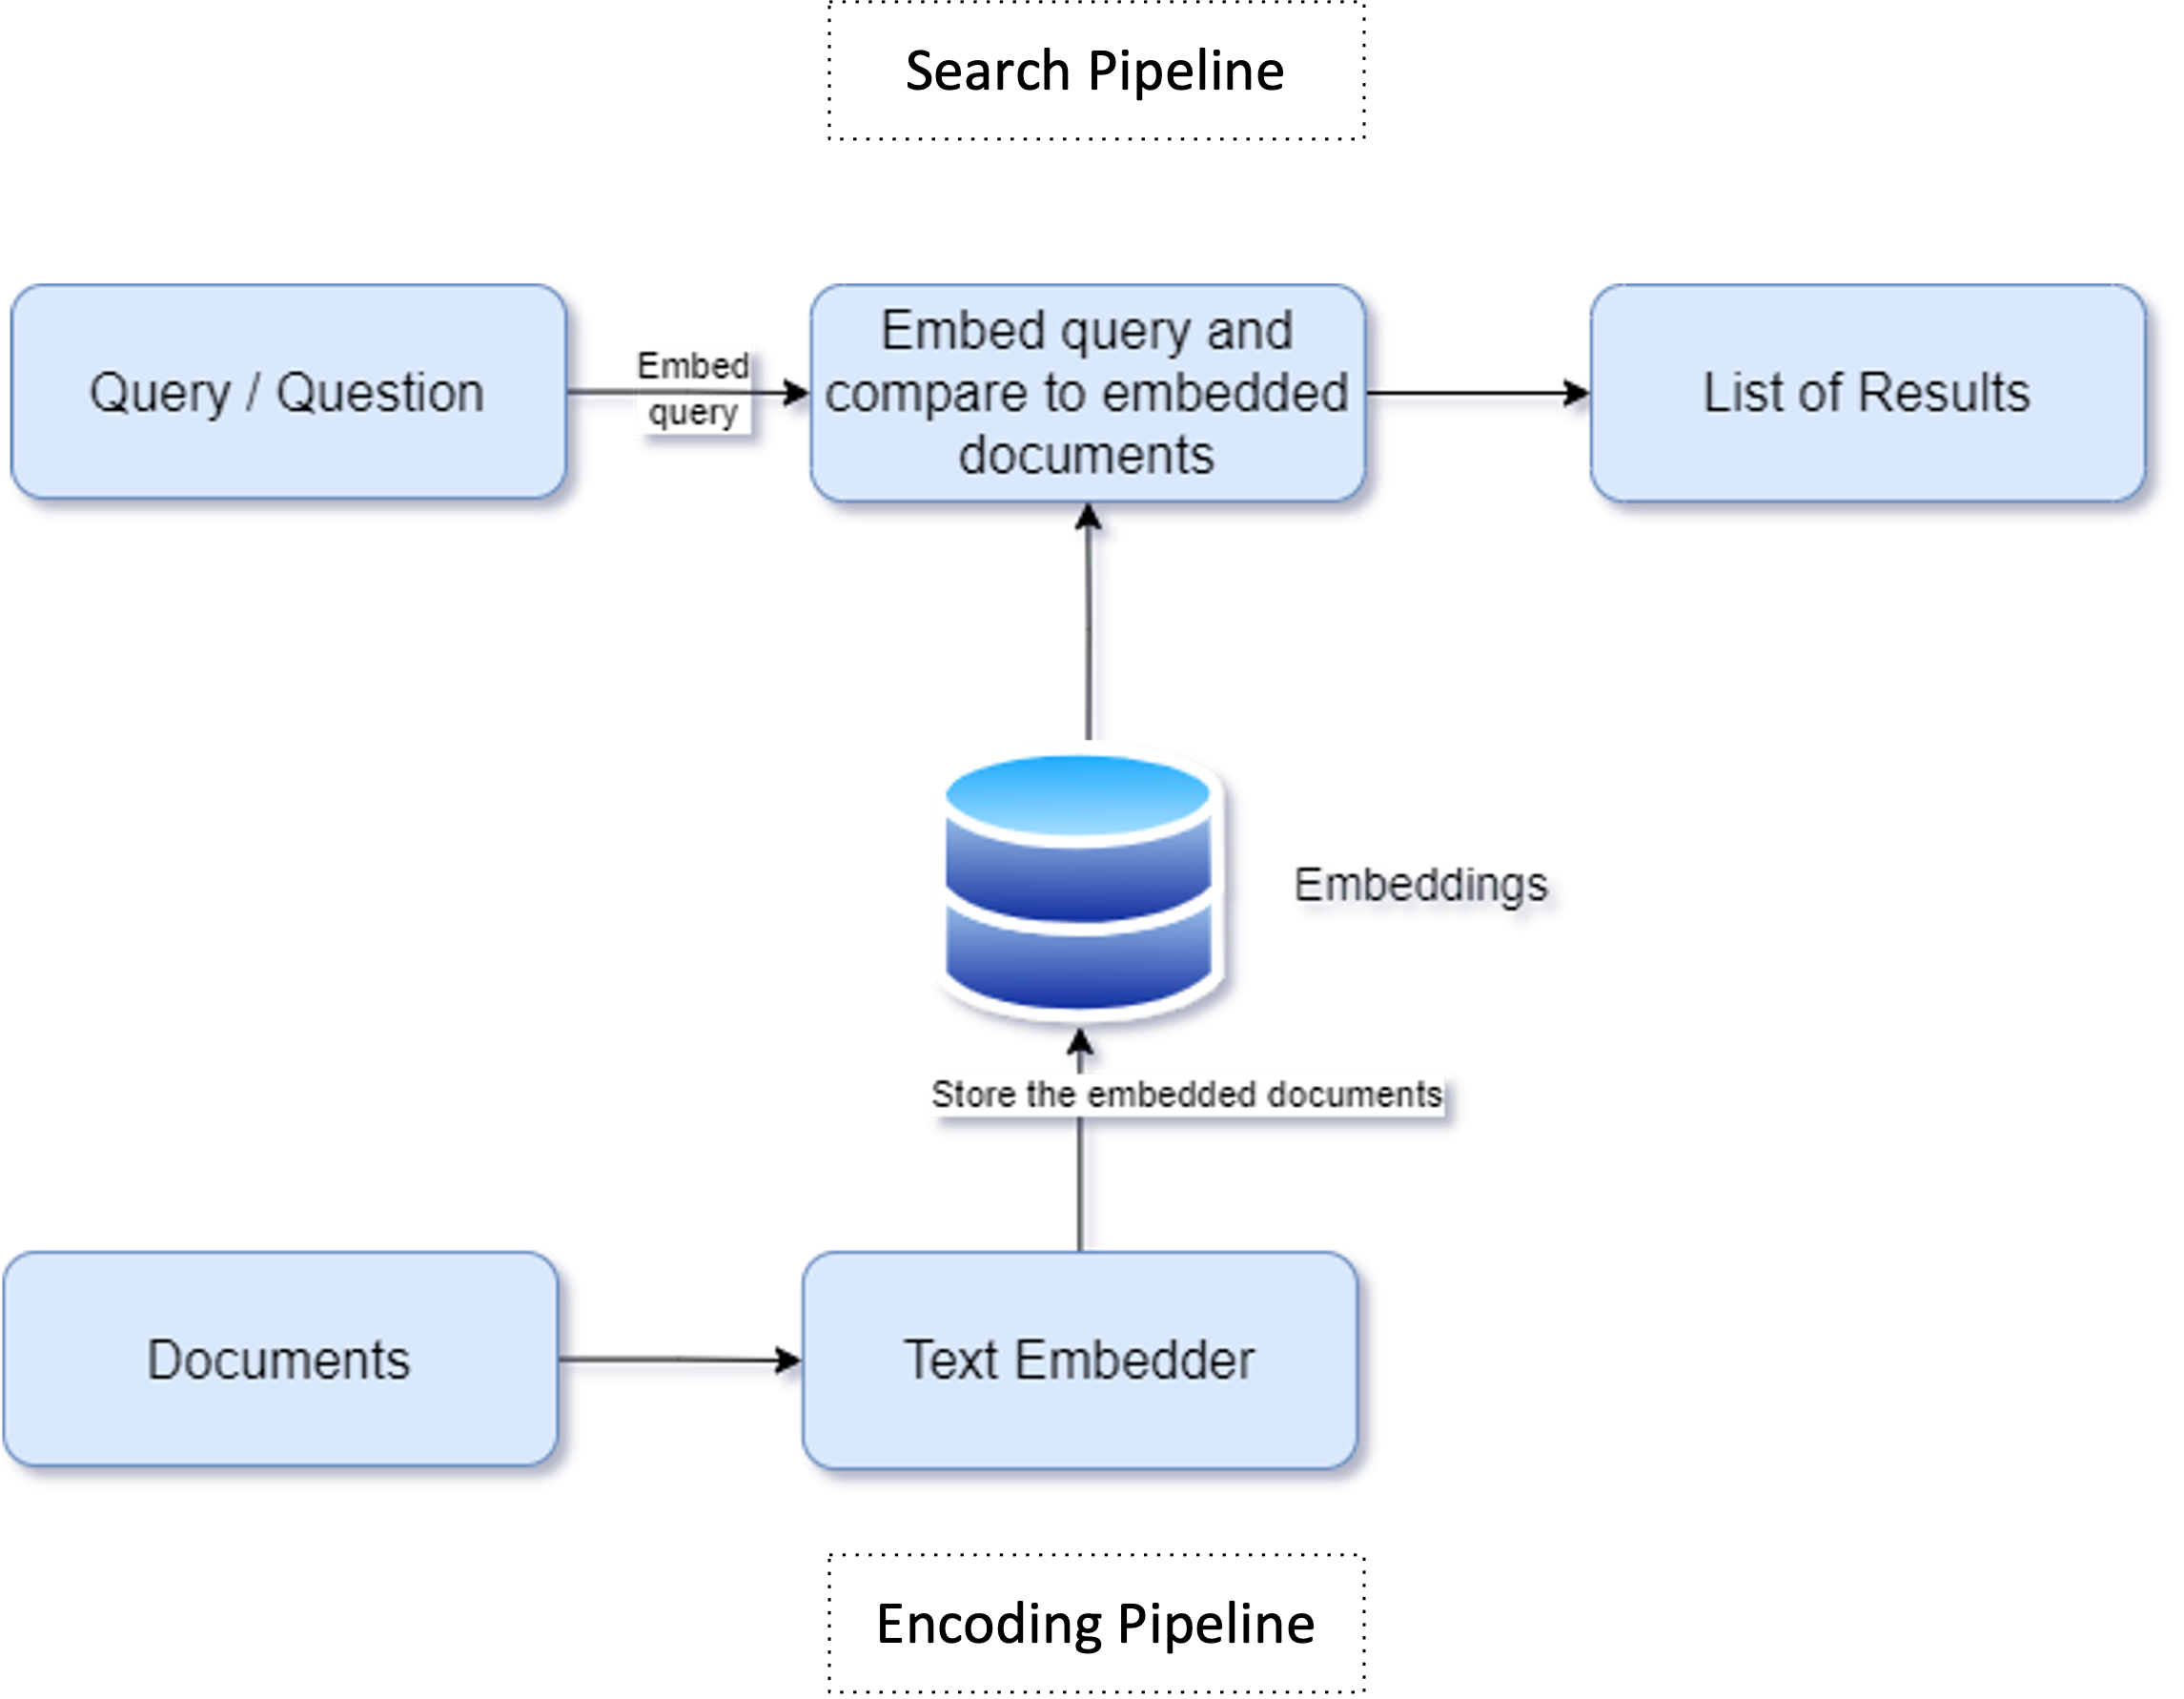

In [64]:
# Read user itnput query
user_query = input()

explain the movie


In [65]:
# Define the function for calculating cosine similarity

def calculate_similarity(embedding1, embedding2):
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2)
    # Convert the result to a Python float
    similarity = cosine_score.item()

    return similarity

In [66]:
# Function to perform semantic search and return ranked chunks
def semantic_search(user_query, df, embedder):

    # Calculate the query embedding
    query_embedding = embedder.encode(user_query, convert_to_tensor=True)

    # Calculate similarity scores between the query embedding and all chunk embeddings
    df['Similarity'] = df['Embeddings'].apply(lambda x: calculate_similarity(query_embedding, x))

    # Sort the DataFrame by similarity scores in descending order
    df = df.sort_values(by='Similarity', ascending=False).reset_index(drop=True)

    # Return only the top 3 values from the dataframe, and drop the embeddings column for a cleaner view of the final results
    df = df.head(3)
    #df.drop('Embeddings', axis = 1, inplace=True)

    return df

In [67]:
# Perform semantic search on each DataFrame
fixed_chunk_results = semantic_search(user_query, fixed_chunk_df, embedder)
para_chunk_results = semantic_search(user_query, para_chunk_df, embedder)
section_chunk_results = semantic_search(user_query, section_chunk_df, embedder)

In [68]:
fixed_chunk_results

,Title,Chunk Text,Embeddings,Similarity
0,The Shawshank Redemption,life. Philosopher Jean-Paul Sartre described f...,"[tensor(0.0046), tensor(0.0042), tensor(-0.087...",0.421436
1,Pulp Fiction,"drugs, fixed fights, dead body disposal, leath...","[tensor(-0.0468), tensor(-0.0834), tensor(0.03...",0.397833
2,The Shawshank Redemption,"too long on supporting characters, or embellis...","[tensor(0.0014), tensor(0.0085), tensor(-0.039...",0.396773


In [69]:
para_chunk_results

,Title,Chunk Text,Embeddings,Similarity
0,The Godfather,The film has been referenced and parodied in v...,"[tensor(-0.0235), tensor(-0.0303), tensor(-0.0...",0.476167
1,Pulp Fiction,"a new phenomenon, the movie whose style is cre...","[tensor(-0.0798), tensor(-0.0132), tensor(0.00...",0.461381
2,The Shawshank Redemption,Many elements can be considered as tributes to...,"[tensor(-0.0112), tensor(0.0389), tensor(-0.04...",0.450636


In [70]:
section_chunk_results

,Title,Section Title,Chunk Text,Embeddings,Similarity
0,Goodfellas,Photography,"The film was shot on location in Queens, Upsta...","[tensor(-0.0134), tensor(-0.0114), tensor(-0.0...",0.388531
1,Pulp Fiction,Legacy and influence,Pulp Fiction quickly came to be regarded as on...,"[tensor(-0.0438), tensor(-0.0542), tensor(-0.0...",0.379481
2,The Shawshank Redemption,Analysis,The film has been interpreted as being grounde...,"[tensor(-0.0556), tensor(0.0511), tensor(-0.08...",0.366787


In [71]:
pip install plotly umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00


In [72]:
import plotly.express as px
import umap

In [73]:
all_results = []

In [74]:
# Check if the 'Embeddings' column exists in each DataFrame
print(f"Columns in fixed_chunk_results: {fixed_chunk_results.columns}")
print(f"Columns in para_chunk_results: {para_chunk_results.columns}")
print(f"Columns in section_chunk_results: {section_chunk_results.columns}")

Columns in fixed_chunk_results: Index(['Title', 'Chunk Text', 'Embeddings', 'Similarity'], dtype='object')
Columns in para_chunk_results: Index(['Title', 'Chunk Text', 'Embeddings', 'Similarity'], dtype='object')
Columns in section_chunk_results: Index(['Title', 'Section Title', 'Chunk Text', 'Embeddings', 'Similarity'], dtype='object')


In [75]:
# Combine all results into a single DataFrame for visualization
all_results = pd.concat([fixed_chunk_results, para_chunk_results, section_chunk_results], ignore_index=True)

# Assuming 'Embeddings' is the column containing embeddings as PyTorch tensors
embeddings = all_results['Embeddings'].tolist()

# Convert PyTorch tensors to NumPy arrays
embeddings = [embedding.cpu().numpy() if hasattr(embedding, 'cpu') else embedding.numpy() for embedding in embeddings]

# Convert the list of embeddings into a 2D NumPy array
X = np.array(embeddings)

# Reduce dimensionality using UMAP
umap_model = umap.UMAP(n_components=2)
umap_embeddings = umap_model.fit_transform(X)

# Add UMAP embeddings as new columns in your dataframe
all_results['umap_x'] = umap_embeddings[:, 0]
all_results['umap_y'] = umap_embeddings[:, 1]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [76]:
print(all_results['Embeddings'].apply(lambda x: len(x)).unique())

[384]


In [77]:
# Visualize the UMAP embeddings using Plotly
fig = px.scatter(all_results, x='umap_x', y='umap_y', hover_data=['Title', 'Chunk Text']) # Changed 'Page Title' to 'Title' and 'Chunk Text' remains unchanged
fig.update_traces(marker=dict(size=3))  # Adjust marker size as needed
fig.show()

In [78]:
# Compute the user query embedding (replace this with your actual query)
user_query_embedding = embedder.encode(user_query, convert_to_tensor=True)

# Assuming user_query_embedding is a NumPy array of shape (1, 384)
# Reduce dimensionality of the user query embedding using the same UMAP model
user_query_umap = umap_model.transform(user_query_embedding.reshape(1, -1))

# Add the user query embedding to the DataFrame
user_query_df = pd.DataFrame({
    'umap_x': user_query_umap[:, 0],
    'umap_y': user_query_umap[:, 1],
    'page title': 'User Query',
    'chunk text': 'User Query'
})

# Concatenate the user query DataFrame with the original results
all_results = pd.concat([all_results, user_query_df], ignore_index=True)

# Specify colors based on a condition
all_results['color'] = np.where(all_results['page title'] == 'User Query', 'User Query Color', 'Other Data Color')

In [79]:
# Visualize the UMAP embeddings with the user query using Plotly
fig = px.scatter(all_results, x='umap_x', y='umap_y', hover_data=['page title', 'chunk text'],
                 color='color', color_discrete_map={'User Query Color': 'red', 'Other Data Color': 'blue'})
fig.update_traces(marker=dict(size=3))  # Adjust marker size as needed
fig.show()

# Modification/Additions to the Notebook

### 2.2 <font color='red'> Sentence-Based Chunking </font>

Sentence-based chunking splits documents into groups of sentences, preserving the natural breaks within the text. This approach helps maintain semantic coherence, which is crucial when working with text data to ensure each chunk retains meaningful information.


In [80]:
import nltk

In [83]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [84]:
from nltk.tokenize import sent_tokenize

def sentence_chunking(text, max_sentences=5):
    """Split the text into chunks of sentences, each containing max_sentences number of sentences."""
    sentences = sent_tokenize(text)
    return [' '.join(sentences[i:i + max_sentences]) for i in range(0, len(sentences), max_sentences)]

# Example Usage
chunks_sentence = sentence_chunking(page.text)
print(f"Generated {len(chunks_sentence)} sentence-based chunks.")

Generated 66 sentence-based chunks.


In [85]:
chunks_sentence

['The Shawshank Redemption is a 1994 American prison drama film written and directed by Frank Darabont, based on the 1982 Stephen King novella Rita Hayworth and Shawshank Redemption. The film tells the story of banker Andy Dufresne (Tim Robbins), who is sentenced to life in Shawshank State Penitentiary for the murders of his wife and her lover, despite his claims of innocence. Over the following two decades, he befriends a fellow prisoner, contraband smuggler Ellis "Red" Redding (Morgan Freeman), and becomes instrumental in a money laundering operation led by the prison warden Samuel Norton (Bob Gunton). William Sadler, Clancy Brown, Gil Bellows, and James Whitmore appear in supporting roles. Darabont purchased the film rights to King\'s story in 1987, but development did not begin until five years later, when he wrote the script over eight weeks.',
 "Two weeks after submitting his script to Castle Rock Entertainment, Darabont secured a $25 million budget to produce The Shawshank Redem


### 2.3 <font color='red'> Token-Based Chunking </font>

Token-based chunking ensures that the document chunks do not exceed a predefined token count. This technique is particularly useful for models that have token input limits, such as LLMs like GPT-3.

In [86]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def token_based_chunking(text, max_tokens=100):
    """Chunk text into pieces with a maximum of max_tokens tokens."""
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_tokens):
        chunk_tokens = tokens[i:i + max_tokens]
        chunk_text = tokenizer.convert_tokens_to_string(chunk_tokens)
        chunks.append(chunk_text)
    return chunks

# Example Usage
chunks_token = token_based_chunking(page.text)
print(f"Generated {len(chunks_token)} token-based chunks.")

Token indices sequence length is longer than the specified maximum sequence length for this model (11047 > 512). Running this sequence through the model will result in indexing errors


Generated 111 token-based chunks.


In [87]:
chunks_token

['the shawshank redemption is a 1994 american prison drama film written and directed by frank darabont, based on the 1982 stephen king novella rita hayworth and shawshank redemption. the film tells the story of banker andy dufresne ( tim robbins ), who is sentenced to life in shawshank state penitentiary for the murders of his wife and her lover, despite his claims of innocence. over the following two decades, he befriends a fellow prisoner, contraband smuggler',
 'ellis " red " redding ( morgan freeman ), and becomes instrumental in a money laundering operation led by the prison warden samuel norton ( bob gunton ). william sadler, clancy brown, gil bellows, and james whitmore appear in supporting roles. darabont purchased the film rights to king \' s story in 1987, but development did not begin until five years later, when he wrote the script over eight weeks. two weeks after submitting his script to castle rock entertainment, darabont',
 "secured a $ 25 million budget to produce the 


### 2.4 <font color='red'> Recursive Chunking </font>

Recursive chunking is used to break down chunks that are too large. If an initial chunk exceeds the size threshold, it is further split into smaller chunks, ensuring all chunks are within manageable limits.

In [88]:
def recursive_chunking(text, max_length=500):
    """Recursively split text into smaller chunks if larger than max_length."""
    if len(text) <= max_length:
        return [text]
    else:
        # Split roughly in the middle
        mid = len(text) // 2
        # Find the nearest space to avoid breaking words
        split_point = mid + text[mid:].find(' ')
        return recursive_chunking(text[:split_point], max_length) + recursive_chunking(text[split_point:], max_length)

# Example Usage
chunks_recursive = recursive_chunking(page.text)
print(f"Generated {len(chunks_recursive)} recursive chunks.")


Generated 128 recursive chunks.


In [89]:
chunks_recursive

['The Shawshank Redemption is a 1994 American prison drama film written and directed by Frank Darabont, based on the 1982 Stephen King novella Rita Hayworth and Shawshank Redemption. The film tells the story of banker Andy Dufresne (Tim Robbins), who is sentenced to life in Shawshank State Penitentiary for the murders of his wife and her lover, despite his claims of innocence. Over the following two decades,',
 ' he befriends a fellow prisoner, contraband smuggler Ellis "Red" Redding (Morgan Freeman), and becomes instrumental in a money laundering operation led by the prison warden Samuel Norton (Bob Gunton). William Sadler, Clancy Brown, Gil Bellows, and James Whitmore appear in supporting roles.\nDarabont purchased the film rights to King\'s story in 1987, but development did not begin until five years later, when',
 ' he wrote the script over eight weeks. Two weeks after submitting his script to Castle Rock Entertainment, Darabont secured a $25 million budget to produce The Shawshan

## 2.5 <font color='red'> Importance of Chunking for Large Language Models (LLMs) </font>

Large Language Models, such as GPT-3 and BERT, have limitations on the number of tokens they can process at once. For instance, GPT-3 can handle up to around 4,096 tokens, depending on the model variant. When dealing with large documents, chunking becomes essential to fit the text within the model's input limits.

Each chunking technique offers unique benefits for LLMs:

- **Sentence-Based Chunking**: Helps retain coherent meaning by grouping sentences, which is beneficial for answering questions about specific ideas or extracting particular information.
- **Token-Based Chunking**: Ensures that chunks do not exceed the model's token limit, providing a reliable way to fit large text pieces into LLMs without truncation.
- **Recursive Chunking**: Guarantees that no chunk exceeds the model's limit by recursively dividing overly large chunks.

These chunking methods allow LLMs to better understand, process, and generate responses based on large documents while preserving the quality and context of the original content.

<font color='red'> Chunking Techniques in Relation to LLM Input Limits </font>

When working with LLMs like GPT-3, each chunk of text must be within the token limit of the model (usually around 4,096 tokens for GPT-3). This section will analyze the chunk sizes produced by different chunking techniques to see if they are well-suited for processing by LLMs.

Ideal Chunk Size: Chunk sizes should ideally be within the model's maximum token capacity to avoid truncation or missing information.
Token Limits for LLMs: We will compare the size distributions of chunks to ensure that none exceeds the maximum token limit, which could result in incomplete analysis or loss of context.

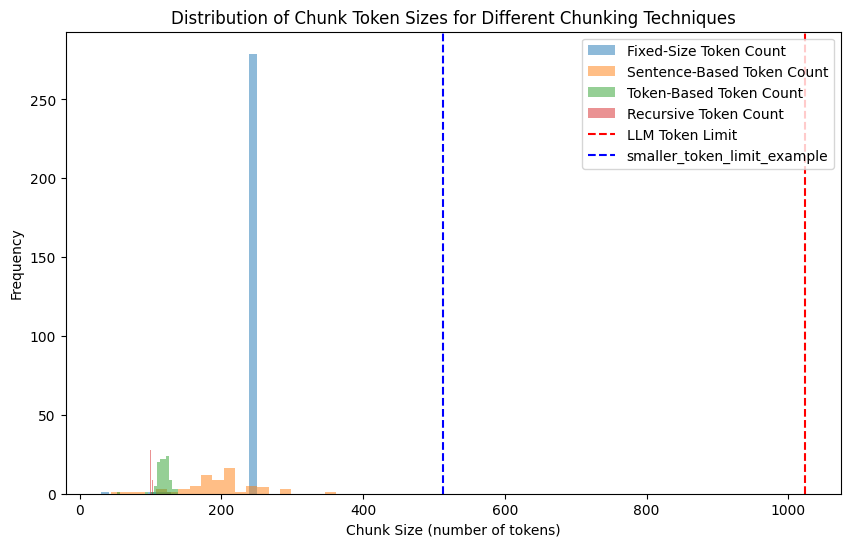

Fixed-Size Chunking: 0 chunks exceed the LLM token limit of 1024 tokens.
Sentence-Based Chunking: 0 chunks exceed the LLM token limit of 1024 tokens.
Token-Based Chunking: 0 chunks exceed the LLM token limit of 1024 tokens.
Recursive Chunking: 0 chunks exceed the LLM token limit of 1024 tokens.


In [90]:
import matplotlib.pyplot as plt

# Assuming a token limit for the LLM, e.g., GPT-2 token limit is around starts around 1024 tokens
llm_token_limit = 1024
smaller_token_limit_example = 512

# Visualizing chunk size distribution for different chunking methods
chunk_methods = {
    "Fixed-Size": fixed_chunk_df['Chunk Text'],
    "Sentence-Based": chunks_sentence,
    "Token-Based": chunks_token,
    "Recursive": chunks_recursive
}

# Convert chunk sizes from characters to approximate token counts (assuming 4-5 characters per token)
def approximate_token_count(text):
    return len(text) // 4  # Assuming an average of 4 characters per token

plt.figure(figsize=(10, 6))
for method, chunks in chunk_methods.items():
    token_counts = [approximate_token_count(chunk) for chunk in chunks]
    plt.hist(token_counts, bins=20, alpha=0.5, label=f"{method} Token Count")

plt.axvline(llm_token_limit, color='red', linestyle='dashed', linewidth=1.5, label="LLM Token Limit")
plt.axvline(smaller_token_limit_example, color='blue', linestyle='dashed', linewidth=1.5, label="smaller_token_limit_example")
plt.xlabel('Chunk Size (number of tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Chunk Token Sizes for Different Chunking Techniques')
plt.legend()
plt.show()

# Summary of chunks exceeding LLM token limit
for method, chunks in chunk_methods.items():
    token_counts = [approximate_token_count(chunk) for chunk in chunks]
    exceeding_chunks = sum(1 for count in token_counts if count > llm_token_limit)
    print(f"{method} Chunking: {exceeding_chunks} chunks exceed the LLM token limit of {llm_token_limit} tokens.")


## 3. <font color='red'> Evaluating Chunk Quality </font>

To ensure that the generated chunks maintain coherence and retain meaningful information, we need to evaluate the quality of each chunk. This section provides two evaluation methods:

1. **Chunk Size Distribution**: Visualizing the distribution of chunk sizes to identify any issues such as very small or very large chunks.
2. **Semantic Similarity Analysis**: Measuring the semantic similarity between each chunk and the original text to ensure that the chunk retains the main themes and information.


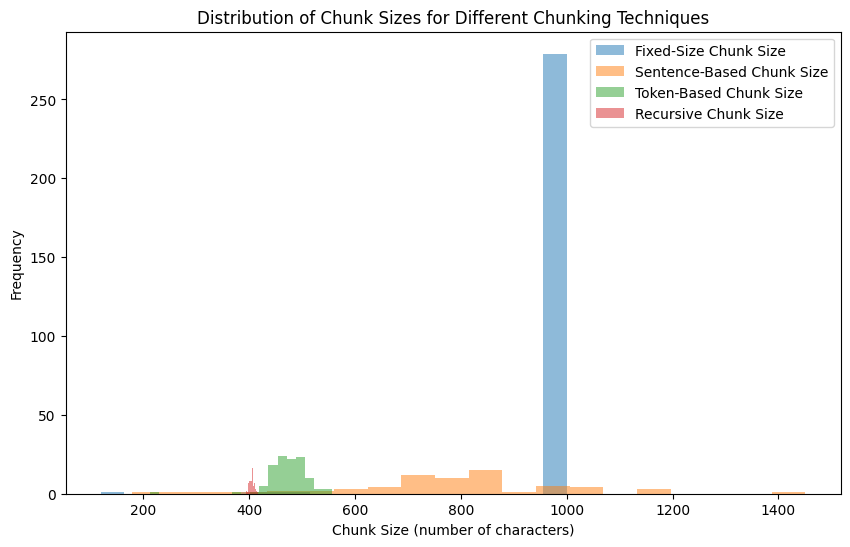

In [91]:
import matplotlib.pyplot as plt

# Visualizing chunk size distribution for different chunking methods
chunk_methods = {
    "Fixed-Size": fixed_chunk_df['Chunk Text'],
    "Sentence-Based": chunks_sentence,
    "Token-Based": chunks_token,
    "Recursive": chunks_recursive
}

plt.figure(figsize=(10, 6))
for method, chunks in chunk_methods.items():
    chunk_sizes = [len(chunk) for chunk in chunks]
    plt.hist(chunk_sizes, bins=20, alpha=0.5, label=f"{method} Chunk Size")

plt.xlabel('Chunk Size (number of characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Chunk Sizes for Different Chunking Techniques')
plt.legend()
plt.show()


In [92]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load the model to compute embeddings for analysis
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Compute the embedding for the original content
original_embedding = model.encode([page.text])

# Function to calculate semantic similarity between chunks and the original text
def calculate_similarity(chunks, original_embedding):
    chunk_embeddings = model.encode(chunks)
    similarities = [cosine_similarity([original_embedding[0]], [chunk_emb])[0][0] for chunk_emb in chunk_embeddings]
    avg_similarity = np.mean(similarities)
    return avg_similarity

# Calculate and print average similarity for each chunking technique
for method, chunks in chunk_methods.items():
    avg_similarity = calculate_similarity(chunks, original_embedding)
    print(f"Average Semantic Similarity for {method} Chunks: {avg_similarity:.2f}")


Average Semantic Similarity for Fixed-Size Chunks: 0.25
Average Semantic Similarity for Sentence-Based Chunks: 0.50
Average Semantic Similarity for Token-Based Chunks: 0.43
Average Semantic Similarity for Recursive Chunks: 0.42


## 4. <font color='red'> Summary and Connecting the Dots with Large Language Models (LLMs) </font>

In this notebook, we explored several key aspects of working with large documents in the context of preparing them for analysis by Large Language Models (LLMs). Here is a summary of the processes covered and how they are essential for leveraging LLMs effectively:

### 4.1 <font color='red'> Document Chunking Techniques </font>

When dealing with LLMs, especially for long documents, chunking is a crucial preprocessing step. Models like GPT-3 and others have a limit on the number of tokens they can process in a single input (e.g., 4,096 tokens for GPT-3). Therefore, chunking becomes necessary to fit the data into these models.

We covered multiple **chunking techniques**, each with its own set of advantages:
- **Fixed-Size Chunking**: Simple but can break up meaningful information.
- **Sentence-Based Chunking**: Retains coherence by grouping sentences, ideal for answering specific questions or maintaining key ideas.
- **Token-Based Chunking**: Designed to manage chunks within token limits, ensuring no truncation by the LLM.
- **Recursive Chunking**: Provides a way to manage very large texts by repeatedly breaking them into smaller, manageable pieces.

### 4.2 <font color='red'> Importance of Evaluating Chunk Quality </font>

Chunking text is only part of the solution. It is equally important to **evaluate the quality of the chunks** to ensure that they provide meaningful input to the LLM. Two key evaluation techniques were introduced:
1. **Chunk Size Distribution**: Visualizing and analyzing chunk sizes to ensure they fit within the LLM's token limits, avoiding truncation or loss of context.
2. **Semantic Similarity Analysis**: Measuring the similarity of each chunk to the original document to ensure that the chunks retain the overall meaning. Higher similarity means the LLM receives chunks that maintain the context, leading to more relevant outputs.

### 4.3 <font color='red'> Embedding Generation and Dimensionality Reduction </font>

We used **Sentence Transformers** to generate embeddings for the chunks. Embeddings represent the semantic content of text in a numerical format that LLMs can easily work with for a wide range of tasks, from semantic search to clustering. We then applied **UMAP** to reduce the dimensionality of these embeddings for visualization, giving us insight into the semantic similarities between chunks.

### 4.4 <font color='red'> Connecting to LLM Use Cases </font>

Each step in this notebook is closely connected to real-world applications of LLMs:

- **Chunking Techniques** ensure that text data is ready for LLMs by breaking down large documents into manageable inputs. This step is foundational for preparing text for tasks like summarization, question-answering, and sentiment analysis.
- **Embedding Generation** transforms text chunks into a numerical format that LLMs can process effectively. This is essential for using LLMs for downstream tasks, such as clustering similar content or searching for related information.
- **Quality Evaluation** is crucial for understanding the effectiveness of chunking and embedding generation. LLMs generate better and more contextually accurate responses when provided with coherent chunks that preserve the main themes and ideas of the original document.

### 4.5 <font color='red'> Practical Applications with LLMs </font>

By applying these chunking techniques and evaluations, you can leverage LLMs in several practical scenarios:

- **Semantic Search**: Breaking down large documents into meaningful chunks and creating embeddings allows for highly effective semantic search, where you can find relevant information based on meaning rather than exact matches.
- **Text Summarization and Question Answering**: Chunking the document appropriately ensures that the LLM receives contextually rich input, leading to more precise and informative answers.
- **Content Organization**: With embeddings, you can cluster and organize content in meaningful ways, enabling efficient navigation and understanding of large datasets.

### 4.6 <font color='red'> Conclusion </font>

In conclusion, this notebook demonstrated the importance of preparing text data for analysis by LLMs through proper **chunking, embedding generation, and evaluation**. Each step contributes to the effectiveness of LLMs in processing large texts and generating meaningful outputs. By understanding how to chunk data appropriately and evaluate the quality of those chunks, you can maximize the potential of LLMs in a wide range of natural language processing tasks, from information retrieval to document summarization.

These concepts form the foundation for effectively utilizing LLMs in any application involving large or complex text datasets, ensuring both the scalability and the relevance of the model's responses.
